# Maximisation couple moyen (non-linéaire)

Ce notebook propose d'optimiser le rotor d'une machine synchro-réluctante sans aimant à une paire de pôle en vue de maximiser le couple moyen.
Dans ce cas particulier, le couple moyen est directement relié à la différence de perméance magnétique du rotor dans l'axe direct d et l'axe en quadrature q.

Le problème étudié est donc la maximisation de cette différence de perméance via la différence de compliance magnétique. Il est possible de démontrer que ce problème est mal posé.

In [2]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry
#from netgen.geom2d import unit_square
import copy
from numpy.random import randint
import numpy as np
import matplotlib.pyplot as plt

importing NGSolve-6.2.2105-9-g5a835126f


## 1) Définition du maillage

La première étape consiste à définir une géométrie (disque), ainsi que la finesse de maillage associée.

In [2]:
#h = 0.1; # ne pas prendre moins de 1/50

#mesh = Mesh(unit_square.GenerateMesh(maxh=h))
#Draw (mesh)

In [3]:
geo = SplineGeometry()

R = 1;
h = R/5; # ne pas prendre moins de R/50

pnts = [(R,-R),(-R,-R),(-R,R),(R,R)]

p = [geo.AppendPoint(*pnt) for pnt in pnts]


geo.Append(["line",0,1],leftdomain=0,rightdomain=1,bc="bottom")
geo.Append(["line",1,2],leftdomain=0,rightdomain=1,bc="left")
geo.Append(["line",2,3],leftdomain=0,rightdomain=1,bc="up")
geo.Append(["line",3,0],leftdomain=0,rightdomain=1,bc="right")

geo.SetMaterial(1, "in")

ngmesh = geo.GenerateMesh(maxh=h)
mesh = Mesh(ngmesh)
Draw (mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2105-9-g5a835126f', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'dr…

BaseWebGuiScene

## 2) Définition des problèmes éléments finis

L'objectif est ici de maximiser la différence de compliance magnétique pour deux chargement distincts. On va résoudre le problème magnétostatique dual ; pour cela, remarquons qu'en l'absence de termes sources:

$$ \overrightarrow{\text{rot}} ~ \overrightarrow{h} = 0 $$

On pose donc $\phi$ un potentiel scalaire tel que $\overrightarrow{h} = \overrightarrow{\text{grad}} ~ \phi$, qui vérifie donc dans $\Omega$:
$$ \text{div}( \mu ~\overrightarrow{\text{grad}} ~ \phi ) = 0 $$

$\phi$ est un champ scalaire qu'on va supposer appartenant à $H^1$. Les conditions aux bords sont de Neumann. La solution est unique à une constante près. Les deux problèmes à résoudre s'écrivent donc :

$$\left \{
\begin{array}{l}
     \text{div}( \mu ~\overrightarrow{\text{grad}} ~ \phi ) = 0 \\
     \frac{\partial \phi}{\partial n} = \Phi ~ \text{sur} ~ \Gamma_1 \bigcup \Gamma_2 \\
     \frac{\partial \phi}{\partial n} = - \Phi ~ \text{sur} ~ \Gamma_3 \bigcup \Gamma_4 
\end{array}
\right. $$

$$\left \{
\begin{array}{l}
     \text{div}( \mu ~\overrightarrow{\text{grad}} ~ \phi ) = 0 \\
     \frac{\partial \phi}{\partial n} = \Phi ~ \text{sur} ~ \Gamma_2 \bigcup \Gamma_3 \\
     \frac{\partial \phi}{\partial n} = - \Phi ~ \text{sur} ~ \Gamma_1 \bigcup \Gamma_4 
\end{array}
\right. $$


Sous forme faible, ce problème s'écrit donc :

$$\forall \psi \in H^1, \underbrace{\int_{\Omega} ~\overrightarrow{\text{grad}} ~ \psi \cdot  \mu ~\overrightarrow{\text{grad}} ~ \phi}_{\text{forme bilinéaire} } = \underbrace{\int_{\Gamma_+} \psi \Phi - \int_{\Gamma_-} \psi \Phi}_{\text{forme linéaire}} $$

Par ailleurs, on suppose que $\mu$ est constante par morceau. On suppose aussi que $\mu$ dépend de $h$ de la façon suivante :

$$ \mu(h) = \mu_0 *\left(1 + 0.25 \frac{20 h}{1 + (20 h)^2 / h_{sat}} \right)  $$

Avec $h_{sat} = 10 kA/m$.

In [ ]:
hsat = 10000
mu0 = 4e-7*np.pi

def h2mu(h):
    return mu0*(1+0.25*(20*h)/(1+np.power((20*h)/hsat,2)))

def h2dmudh(h)
    return - mu0*(5*hsat**2*(np.power((20*h),2)-hsat**2))/np.power(np.power((20*h),2)+hsat**2,2)

h = np.linspace(0,10000,1000)
plt.plot(h,mu(h)*h)
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")
plt.title("Modèle de courbe BH")
plt.grid()
plt.show()

On définit ensuite les densités

In [ ]:
fespace_rho = L2(mesh, order=0)
 
rho = GridFunction(fespace_rho)
rho.vec[:] = 0.5

#rho.vec[:] = 0.2*np.random.randint(0,5,len(rho.vec[:].FV().NumPy()))
rho.vec.FV().NumPy()[mask.vec.FV().NumPy()[:]==1] = 0.5

def getMu(rho,h):
    mu = copy(rho)
    mu.vec[:] = mu0 + (h2mu(h)-mu0) * rho
    
    return mu


On définit ensuite la stratégie de résolution non-linéaire. On utilise la méthode de Newton, qui consiste à annuler une fonction (le résidu) par approximations affines successives.
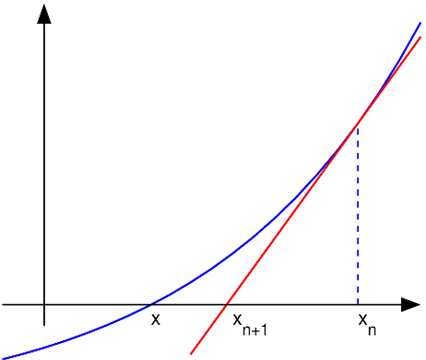

En dérivant le résidu, on trouve :

$$ \overbrace{\langle h^*, \partial_h [\mu(h_k) h_k] \underbrace{(h_{k+1} - h_k)}_{\Delta h_k} \rangle}^{\text{dérivée du résidu}} + \underbrace{\langle h^*, \mu(h_k) h_k \rangle - l_k(h^*)}_{\text{résidu}} = 0 $$

Avec 

$$\partial_h [\mu(h_k) h_k] = I_d \mu(h_k) + h_k \otimes \partial_|h| \mu . \mathrm{d}_\phi |h|$$

Après avoir résolu cette équation, on trouve :

$$ h_{k+1} = h_k + \Delta h_k $$

(On peut éventuellementmettre un coefficient d'amortissement)

In [4]:
PHI = 1;


def residu_pb12(rho,h)

    fespace_H1 = H1(mesh, order=1)
    fespace_H1.FreeDofs()[0] = False
    phi = fespace_H1.TrialFunction()
    psi = fespace_H1.TestFunction()
    K = BilinearForm(fespace_H1, symmetric=True)
    K +=  grad(psi) * getMu(rho,h) * grad(phi)*dx
    
    K.Assemble()
    
    l1 = LinearForm(fespace_H1)
    l1 += -psi*PHI*ds(definedon=mesh.Boundaries("bottom"))
    l1 += psi*PHI*ds(definedon=mesh.Boundaries("up"))
    l1.Assemble()
    
    l2 = LinearForm(fespace_H1)
    l2 += -psi*PHI*ds(definedon=mesh.Boundaries("left"))
    l2 += psi*PHI*ds(definedon=mesh.Boundaries("right"))
    l2.Assemble()
    
    return(K.mat * h.vec - l1.vec , K.mat * h.vec - l2.vec)
    
def getDmuhdh(rho,h):
    dmudh = h2dmudh(h)*rho # dérivée par rapport à la norme de h
    
    dhdHx = 
    dhdHy = 

    
def derivee_pb12(rho,h)

    fespace_H1 = H1(mesh, order=1)
    fespace_H1.FreeDofs()[0] = False
    
    dmudh = h2dmudh(h)*rho
    
    

def solvePb(mu):
    fespace_H1 = H1(mesh, order=1)
    fespace_H1.FreeDofs()[0] = False
    phi = fespace_H1.TrialFunction()
    psi = fespace_H1.TestFunction()
    K = BilinearForm(fespace_H1, symmetric=True)
    K +=  grad(psi)*mu*grad(phi)*dx

    n= specialcf.normal(mesh.dim);

    l1 = LinearForm(fespace_H1)
    l1 += -psi*PHI*ds(definedon=mesh.Boundaries("bottom"))
    l1 += psi*PHI*ds(definedon=mesh.Boundaries("up"))

    l2 = LinearForm(fespace_H1)
    l2 += -psi*PHI*ds(definedon=mesh.Boundaries("left"))
    l2 += psi*PHI*ds(definedon=mesh.Boundaries("right"))
    
    K.Assemble()
    l1.Assemble()
    l2.Assemble()
    
    phi1 = GridFunction(fespace_H1)  # solution
    phi1.vec.data =     K.mat.Inverse(inverse="sparsecholesky") * l1.vec
    phi2 = GridFunction(fespace_H1)  # solution
    phi2.vec.data =     K.mat.Inverse(inverse="sparsecholesky") * l2.vec
    
    return(phi1, phi2)
    
fespace_mu = L2(mesh, order=0)    
mu = GridFunction(fespace_mu)
s = (randint(3, size=len(mu.vec[:].FV()))+1)-2
mu.vec[:] = 4e-7*3.14*1.5 #(2+s[:])

In [5]:
phi1, phi2 = solvePb(mu)

In [6]:
#Draw (grad(phi2), mesh,vectors = { "grid_size":20});
#Draw (InnerProduct(grad(phi1),grad(phi1))-InnerProduct(grad(phi2),grad(phi2)), mesh);

In [7]:
Draw (phi2, mesh);

WebGuiWidget(value={'ngsolve_version': '6.2.2105-9-g5a835126f', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'dr…

## 3) Optimisation

Le problème est auto-adjoint. Ainsi, l'adjoint s'écrit $\psi = -\phi$ et l'identification $\mathcal{L}^2$ du gradient par rapport à $\mu$ s'écrit:
$$\partial_\mu \mathcal{L} = -|\nabla \phi|^2 $$

In [8]:
def gradient(phi1,phi2):
    return(-grad(phi1)*grad(phi1) + grad(phi2)*grad(phi2))

def objective(phi1,phi2,mu):
    return(Integrate(grad(phi1)*mu* grad(phi1) -  grad(phi2)*mu* grad(phi2), mesh))


In [9]:
J=[]
mu0 = 4e-7*3.14
mu_max = 3* mu0
step = (mu_max-mu0)/10
g = GridFunction(fespace_mu)
G=[]
MU=[]
for i in range(70):
    phi1, phi2 = solvePb(mu)
    g.Set(gradient(phi1,phi2))
    g.vec[:]= np.sign(g.vec[:].FV().NumPy())
    J.append(objective(phi1,phi2,mu))
    MU.append(copy.copy(mu))
    G.append(copy.copy(g))
    print(f'{J[-1]} - normalized step : {step/(mu_max-mu0)}')
    
    #if i>0 and J[-1]< J[-2]:
        #step = step*1.2
    #elif i>0:
        #step = step/2
    mu.Set(MU[i] - G[i]*step)
    mu.vec[:].FV().NumPy()[mu.vec[:].FV().NumPy()<mu0]=mu0
    mu.vec[:].FV().NumPy()[mu.vec[:].FV().NumPy()>mu_max]=mu_max

-5.0642508315803426e-09 - normalized step : 0.09999999999999999
3331.411669954931 - normalized step : 0.09999999999999999
-34158.64367177563 - normalized step : 0.09999999999999999
-92678.49850198603 - normalized step : 0.09999999999999999
-151496.77524691226 - normalized step : 0.09999999999999999
-211586.2058428725 - normalized step : 0.09999999999999999
-257516.32608099567 - normalized step : 0.09999999999999999
-301054.2431805565 - normalized step : 0.09999999999999999
-333474.56371144875 - normalized step : 0.09999999999999999
-357688.5294704222 - normalized step : 0.09999999999999999
-371720.9178399197 - normalized step : 0.09999999999999999
-375901.32571316854 - normalized step : 0.09999999999999999
-378180.65927703853 - normalized step : 0.09999999999999999
-379640.9549131592 - normalized step : 0.09999999999999999
-380661.246532979 - normalized step : 0.09999999999999999
-381613.36645398143 - normalized step : 0.09999999999999999
-382667.4395086492 - normalized step : 0.099999

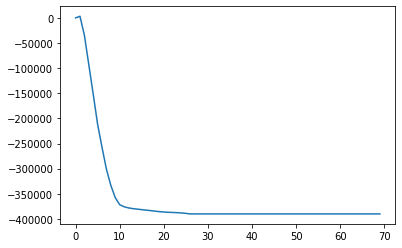

In [10]:
g.vec.FV().NumPy()
plt.plot(J)
#Draw(MU[0],mesh,min=mu0,max=mu_max)

In [11]:
Draw(MU[15],mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2105-9-g5a835126f', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'dr…

BaseWebGuiScene

In [12]:
Draw(10*mu+g,mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2105-9-g5a835126f', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'dr…

BaseWebGuiScene

In [13]:
Draw(InnerProduct(-grad(phi1),grad(phi1))+InnerProduct(grad(phi2),grad(phi2)),mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2105-9-g5a835126f', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'dr…

BaseWebGuiScene

In [14]:
help(Draw)

Help on function Draw in module ngsolve.webgui:

Draw(mesh_or_func, mesh_or_none=None, name='function', order=2, min=None, max=None, draw_vol=True, draw_surf=True, autoscale=True, deformation=False, interpolate_multidim=False, animate=False, clipping=None, vectors=None, js_code=None, eval_function=None, eval=None, filename='')



In [15]:
phi1, phi2 = solvePb(mu)
g = gradient(phi1,phi2)
Draw(mu,mesh)
a = mu+g

WebGuiWidget(value={'ngsolve_version': '6.2.2105-9-g5a835126f', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'dr…

In [16]:
Draw(gradient(phi1,phi2),mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2105-9-g5a835126f', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'dr…

BaseWebGuiScene

In [17]:
Integrate((grad(phi1)*mu* grad(phi1) - grad(phi2)*mu* grad(phi2))*dx)

TypeError: Integrate(): incompatible function arguments. The following argument types are supported:
    1. (cf: ngsolve.fem.CoefficientFunction, mesh: Union[ngsolve.comp.Mesh, ngsolve.comp.Region], VOL_or_BND: ngsolve.comp.VorB = <VorB.VOL: 0>, order: int = 5, definedon: ngsolve.comp.Region = None, region_wise: bool = False, element_wise: bool = False) -> object
    2. (igls: ngsolve.comp.SumOfIntegrals, mesh: ngsolve.comp.Mesh, element_wise: bool = False) -> object

Invoked with: <ngsolve.comp.SumOfIntegrals object at 0x7f9d087ab830>

In [ ]:
(grad(phi1)*mu* grad(phi1) - grad(phi2)*mu* grad(phi2))*dx

In [ ]:
grad(phi1)*mu* grad(phi1) - grad(phi2),mu* grad(phi2)

In [ ]:
g.vec[:]= g.vec[:].FV().NumPy()/max(g.vec[:])

In [ ]:
Integrate(grad(phi1)*mu* grad(phi1) - grad(phi2)*mu* grad(phi2), mesh)

In [ ]:
J=[]
step = 0.1
g = GridFunction(fespace_mu)

In [ ]:
help(Draw)

In [ ]:
a.datavec.FV()[:] = a.vec.FV()[:] /max(a.vec.FV()[:] )